# Dispersion coefficients from TDDFT

Dispersion interaction is a weak attractive interaction that binds even neutral, noble gas atoms to each other. Dispersion interaction sometimes mistakenly called the van der Waals (vdW) interaction, which is not correct. VdW-interactions are a combination of intermolecular interactions, where permanent molecular dipoles induce and interact with other molecular dipoles. Despite being the weakest form of van der Waals forces, dispersion interactions significantly influence the structure, stability, and properties of molecular systems, including biological molecules like proteins and DNA. 

Dispersion interaction is caused by fluctuations in the electron densities in an atom or a molecule. The fluctuations cause intantaneous electric fields that are felt by ther nearby atoms or molecules, which respond to the electric field by adjusting their own electron densities accordingly. These instantaneous dipole moments then attract each other, resulting in the dispersion interaction. 

While other van der Waals force are well described by the computational chemistry workhorse, the density functional theory (DFT), the dispersion interaction is not. Traditional DFT methods struggle to accurately predict dispersion interaction, because the electron-electron interaction is only treated approximately, without directly accounting for the correlated motion of electrons. Instead, the dispersion is usually included in the DFT calculations as a separate correction. Using the Rayleigh--Schrödinger perturbation theory, one can show that the potential energy between two weakly interacting systems is proportional to the inverse sixth power of the distance between them, leading to the well-known $$V(r) \propto -\frac{C_6}{r^6}$$ where $C_6$ is the dispersion coefficient and $r$ is the intermolecular distance.

Here, we will have a look at how the dispersion coefficient $C_6$ can be computed using time-dependent DFT (TD-DFT)-

### Oscillator strengths


Oscillator


### PySCF

We will use PySCF for computing the 

In [5]:
import numpy as np
from pyscf import gto, scf, tddft, dft

mol = gto.Mole()
mol.atom = '''
  H   0.52802620386669      0.16080585704645      0.93445833623999
  C   -0.00000013164920     -0.00000003688791     -0.00001983912221
  H   0.20482495707463      0.82278316161070     -0.67751109648300
  H   0.33402443695916     -0.92997571538955     -0.44889922291678
  H   -1.06687546625128     -0.05361325637969      0.19187182228200
'''
mol.basis = 'def2-TZVP'
mol.build()

# Perform the ground state SCF calculation
#mf = scf.RHF(mol)
mf = dft.RKS(mol)
mf.xc = 'pbe'
mf.verbose = 0
mf.kernel()

# Perform the TDDFT calculation
td = tddft.TDDFT(mf)
td.nstates = 250  # Number of excited states to compute
td.max_cycle = 100
td.verbose = 0
td.run()

As well as the harmonic potential:

In [6]:
f = td.oscillator_strength()
w0 = td.e
C6 = 0

w = np.linspace(0, np.min(w0), 100)
a = np.zeros(w.shape)
for k in range(len(f)):
    for l in range(len(f)):
        C6 += f[k]*f[l] / ((w0[k] + w0[l]) * w0[k]*w0[l]) * 3/2
print(C6)

106.32524102120554


In [8]:
len(f)

250

Combining the two components results in the full Hamiltonian. Diagonalization of the Hamiltonian gives us the eigenvalues and -vectors. 

In [6]:
H = -0.5 * Dxx + V
e, wf = np.linalg.eigh(H)

The ground state is the eigenstate corresponding to the lowest eigenvalue. The eigh-function already sorts the eigenstate in an ascending order of the eigenvalues, so the ground state corresponds to the first entry on the list. The eigenvectors are spanned on the real space grid and so we can plot it on the grid. However, the wavefunction needs to be correctly normalized. The norm of the wavefunction can be computed on the grid as
\begin{equation}
    \int_{-\infty}^\infty \psi(x)^2 dx \approx \sum_i \left|\psi(x_i)\right|^2 h = 1
\end{equation}
and so we need to account for the grid spacing in our eigenvectors by dividing them with the square root of the grid spacing. Let's compare our numerical solution with the exact analytical solution on the same grid.

Numerical ground state energy 0.4997
Exact ground state energy 0.5000


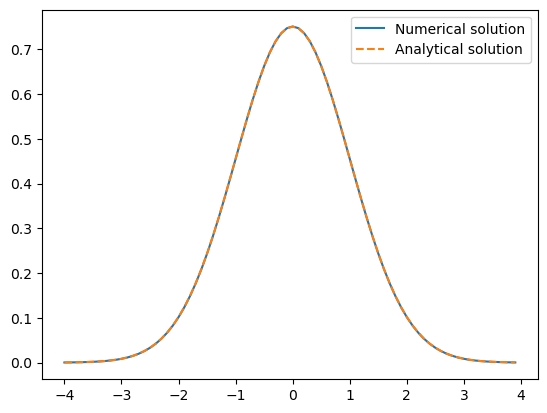

In [7]:
import matplotlib.pyplot as plt
e0 = e[0]
wf0 = wf[:,0] / h**0.5
wf0_analytical = np.pi**-0.25 * np.exp(-0.5*x**2)
print(f'Numerical ground state energy {e0:.4f}')
print(f'Exact ground state energy 0.5000')
plt.plot(x, wf0, label='Numerical solution')
plt.plot(x, wf0_analytical, linestyle='dashed', label='Analytical solution')
plt.legend()
plt.show()

### Conclusion

Regardless whether the quantum system consists of a single particle or many particles, the system is solved by constructing the Hamiltonian and then diagonalizing it. This will be our goal in the Hartree--Fock approach as well. However, with many particle systems we face the issue of electron--electron interaction. We will therefore first construct a sort of approximate Hamiltonian that we will solve iteratively (using the self-consistent field). We will then use the eigenstates of the Hartee--Fock solution to build the exact Hamiltonian (configuration interaction). It must be emphasized that in the Hartree--Fock method, we make no approximations to the Hamiltonian per se. The Hartree--Fock approximation is to write the antisymmetric wavefunction in terms of only a single Slater determinant. This results in some of the electron--electron integrals to become zero, effectively resulting in an "incomplete" Hamiltonian, called the Fockian matrix.